# Contrastive Learning Evaluation

## Common Imports and Settings

In [7]:
import sys
sys.path.insert(0, "/home/jupyter/ML_for_slideseq/src")

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torchvision
import torch
import tissue_purifier as tp

matplotlib.rcParams["figure.dpi"] = 200

/opt/conda/lib/python3.7/site-packages/lightly/api/version_checking.py:57: Warning: You are using lightly version 1.1.13. There is a newer version of the package available. For compatability reasons, please upgrade your current version: pip install lightly==1.1.14
  warnings.warn(Warning(warning))


In [10]:
root = "/home/jupyter/data/slide-seq/original_data/"

df_wt1 = pd.read_csv(root + "wt_1.csv")
df_wt2 = pd.read_csv(root + "wt_2.csv")
df_wt3 = pd.read_csv(root + "wt_3.csv")
df_dis1 = pd.read_csv(root + "sick_1.csv")
df_dis2 = pd.read_csv(root + "sick_2.csv")
df_dis3 = pd.read_csv(root + "sick_3.csv")

In [11]:
NUM_WORKERS = 8
BATCH_SIZE = 128
SEED = 1
MAX_EPOCHS = 100
INPUT_SIZE = 224
NUM_FTRS = 128
PROJECTION_OUT_DIM = 128
PIXEL_SIZE = 4.0
CROP_SIZE = INPUT_SIZE
INPUT_CHANNELS = 9
N_ELEMENT_MIN = 200
N_CROPS_TEST = 350

# Optimizer parameters:
LEARNING_RATE = 0.001
IS_SCHEDULED = True
SCHEDULER_STEP = 3,
SCHEDULER_GAMMA = 0.995

## Get Data

In [12]:
all_df = [df_wt2, df_dis2]
labels_sparse_images = [0, 1]

sparse_images = tp.data_utils.SparseImage.from_pandas(all_df, "x", "y", "cell_type", PIXEL_SIZE)

number of elements ---> 33059
The dense shape of the image is -> torch.Size([9, 1170, 845])
number of elements ---> 42776
The dense shape of the image is -> torch.Size([9, 1170, 1170])


In [13]:
test_dataloader = tp.data_utils.helpers.define_dataloader_test(
    sparse_images=sparse_images,
    labels_sparse_images=labels_sparse_images,
    input_size=INPUT_SIZE,
    crop_size=CROP_SIZE,
    n_crops_test=N_CROPS_TEST,
    n_element_min=N_ELEMENT_MIN,
    batch_size=BATCH_SIZE
)

## Load Model

Here we use model trained from the tp_03 notebook

In [14]:
model = tp.model_utils.helpers.define_model(
    number_of_channels=INPUT_CHANNELS,
    num_of_filters=NUM_FTRS,
    projection_out_dim=PROJECTION_OUT_DIM
)
optimizer, scheduler = tp.model_utils.helpers.define_optimizer_and_scheduler(
    model=model,
    num_epochs=MAX_EPOCHS,
    learning_rate=LEARNING_RATE,
    scheduler_step_size=SCHEDULER_STEP,
    scheduler_gamma=SCHEDULER_GAMMA
)
criterion = tp.loss_utils.helpers.define_contrastive_loss()

As long as lightly's model Embedding predicts out of backbone (ignoring projection head) 
tissue purifier provides a wrapper

In [15]:
# model.load_state_dict(torch.load("simclr_model.pt"))

In [16]:
ckpt = torch.load("model.pth")
model.backbone.load_state_dict(ckpt['resnet18_parameters'])

<All keys matched successfully>

In [17]:
model = model.to("cuda")

In [18]:
import lightly
encoder = tp.model_utils.ProjectionHeadEmbedding(
# encoder = lightly.embedding.SelfSupervisedEmbedding(
    model,
    criterion,
    optimizer,
    test_dataloader
)

## Get Embeddings

In [19]:
embeddings, labels, fnames = encoder.embed(test_dataloader, device="cuda", to_numpy=True)

Compute efficiency: 0.13: 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


In [20]:
embeddings.shape

(700, 128)

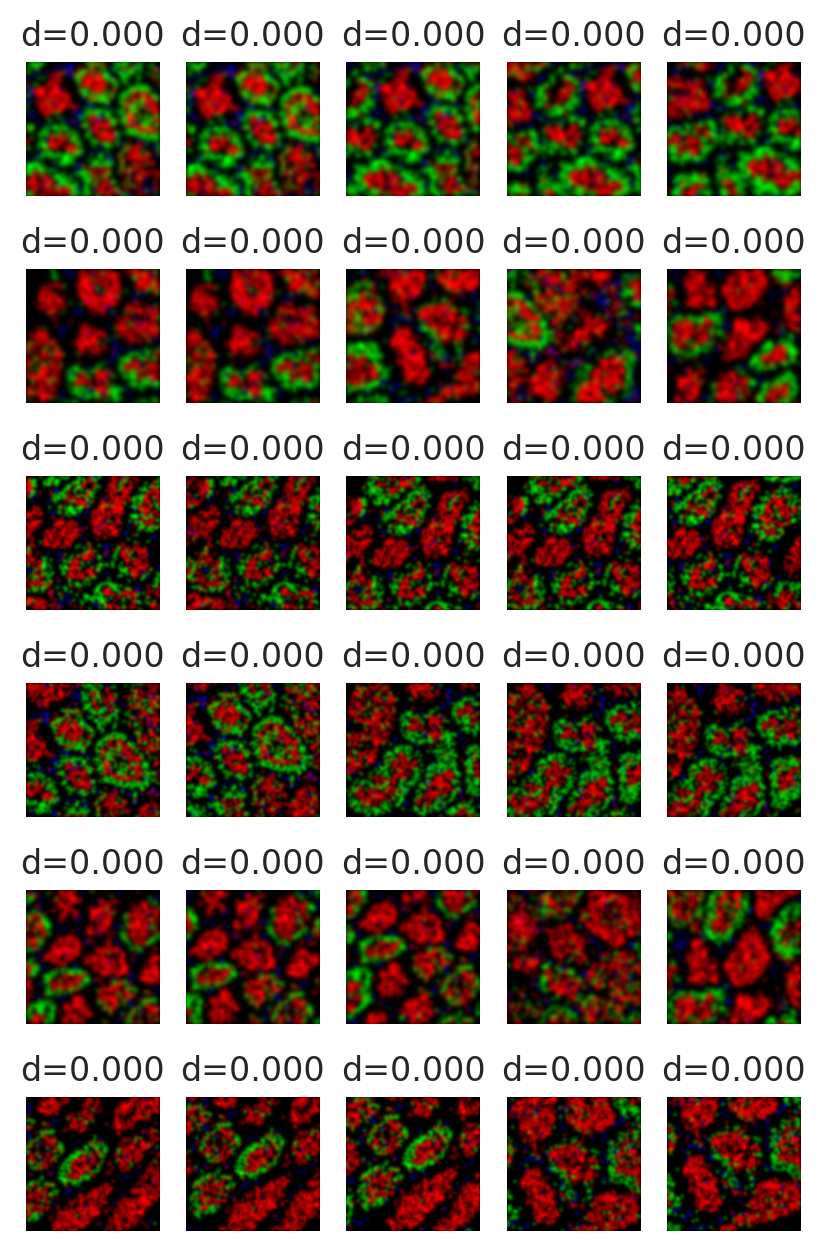

In [21]:
tp.plot_utils.plot_knn_examples(embeddings, test_dataloader, figsize=(5, 8), n_neighbors=5)

## UMAP

In [16]:
umap_embeddings = tp.evaluation_utils.get_umap(embeddings=embeddings)

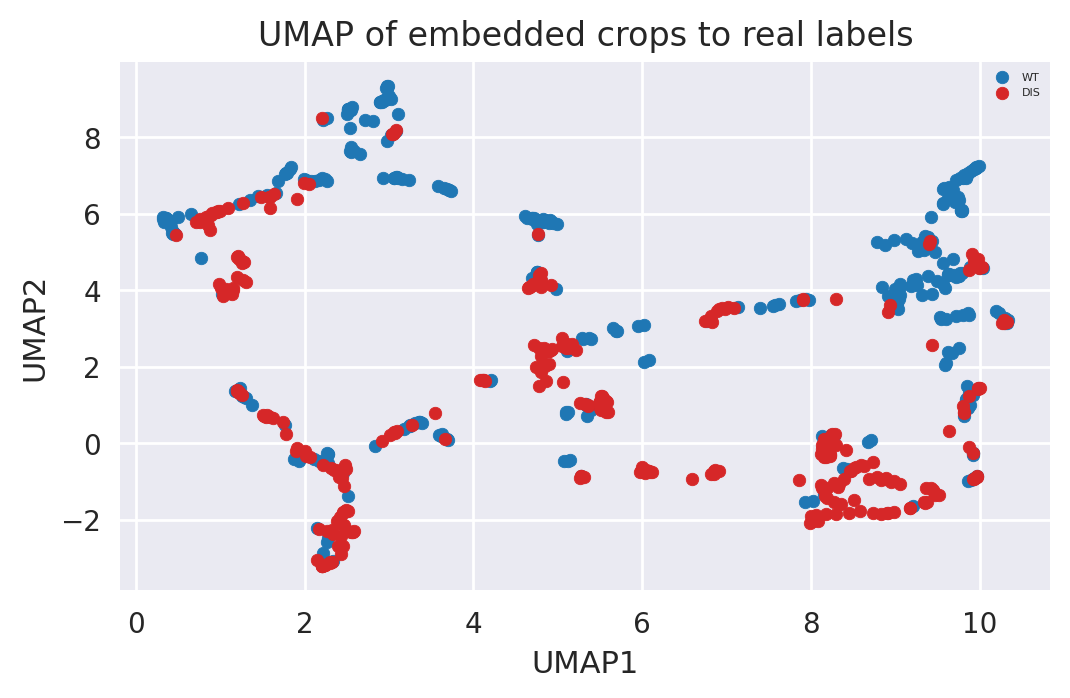

In [17]:
tp.plot_utils.umap_binary_label(umap_embedded=umap_embeddings, labels=labels)

In [30]:
%%capture
morans = tp.evaluation_utils.get_morans(test_dataloader, all_df=all_df, pixel_size=PIXEL_SIZE, crop_size=CROP_SIZE)

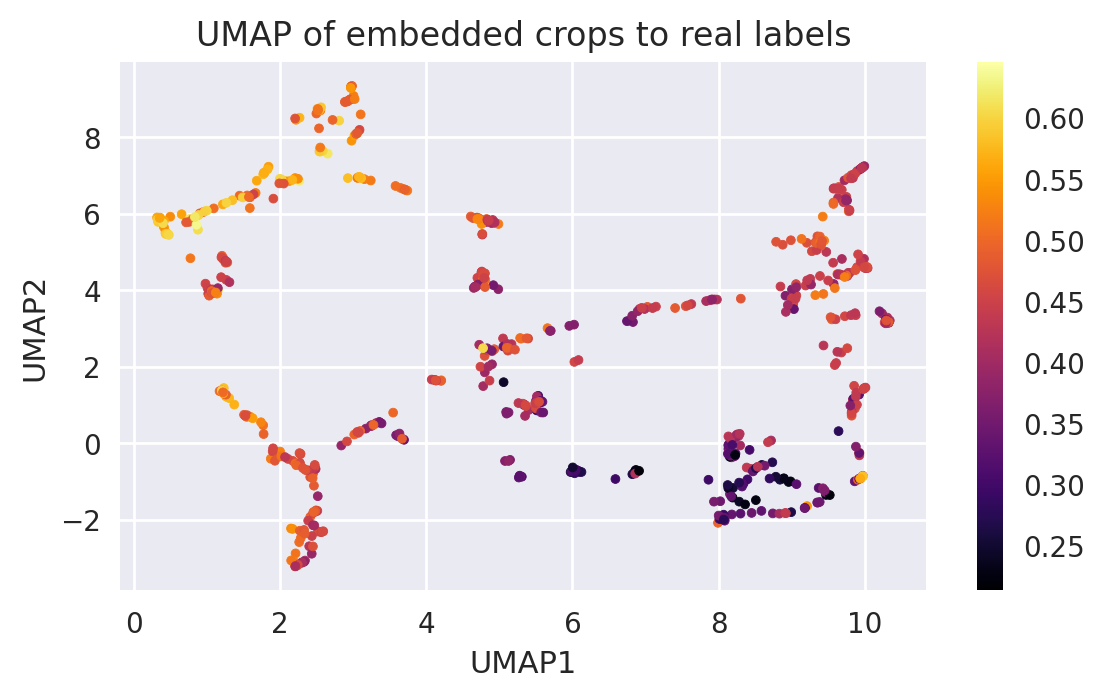

In [19]:
tp.plot_utils.umap(umap_embedded=umap_embeddings, colors=morans)

## PCA

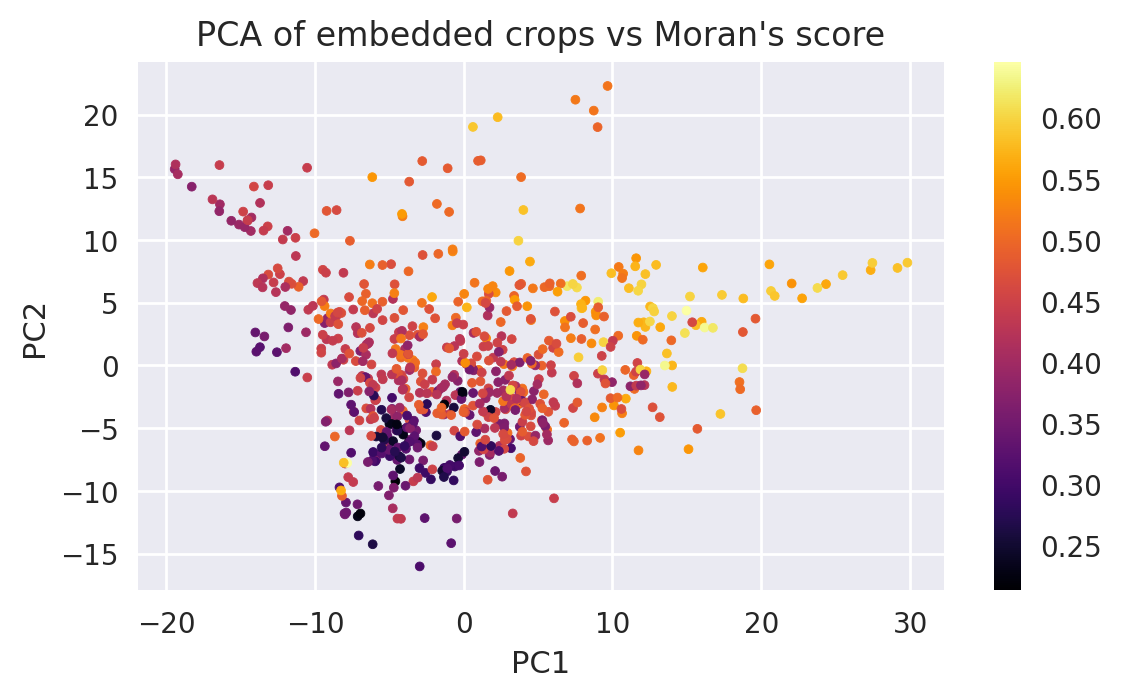

In [21]:
pca_emb = tp.evaluation_utils.get_pca(embeddings)
tp.plot_utils.pca(pca_emb, morans)

## tSNE

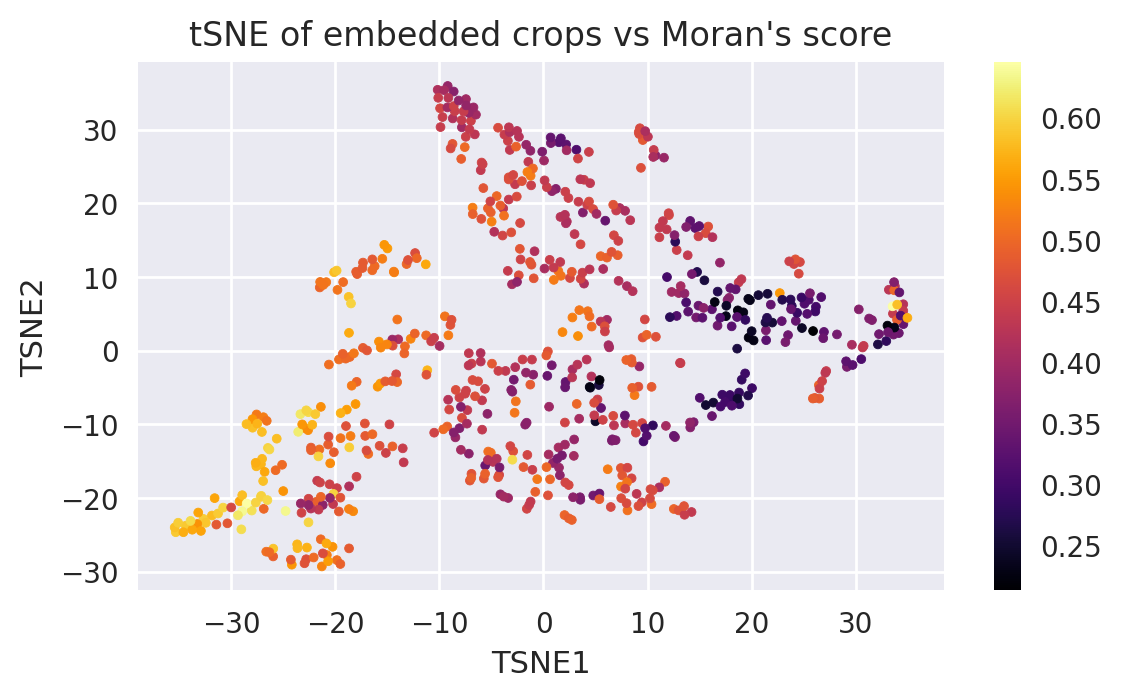

In [23]:
tsne_emb = tp.evaluation_utils.get_tsne(embeddings)
tp.plot_utils.tsne(tsne_emb, morans)

## Tensorflow Projector

`projector.tar.gz` compressed file or `projector` folder (depends on `apply_compress` boolean flag passed to `tp.evaluation_utils.create_projector` function) will appear in the same directory as current notebook. 

In [32]:
tp.evaluation_utils.create_projector(
    test_dataloader, embeddings, {"labels": labels, "morans": morans}
)

To run a [tensorflow projector](http://projector.tensorflow.org/) you only need to go to command-line in the same directory as current notebook and execute:
```
$ tensorboard --logdir ./projector
```

So now you can go to `http://localhost:6006/#projector` and see the data visualisation in 3D space embedded with different algorithms (UMAP, tSNE, PCA).

Note: you need to have a [tensorboard](https://github.com/tensorflow/tensorboard) installed before

Or it is possible to run in your notebook:

**Note:** it is required to have `projector` dir in the same directory as notebook, 
so either unzip `projector.tar.gz` or pass `apply_compress=False` before calling `tp.evaluation_utils.create_projector`

In [22]:
from tensorboard import notebook

notebook.start("--logdir projector")

Reusing TensorBoard on port 6007 (pid 8865), started 0:02:06 ago. (Use '!kill 8865' to kill it.)